In [ ]:
!pip install quimb

In [7]:
import quimb.tensor as qtn
A = qtn.tensor_1d.MatrixProductState

# Check if multiply exists
print(hasattr(A, 'multiply'))

True


In [8]:
import numpy as np

def riemann_step(N):
    """Create a Riemann step function of length N as a NumPy float array."""
    half = N // 2
    return np.concatenate([
        np.ones(half, dtype=np.float32),
        np.zeros(N - half, dtype=np.float32)
    ])

Initial MPS bond dimensions (max): 1
MPO for d/dx bond dimensions (max): 5
MPO for d^2/dx^2 bond dimensions (max): 5

Starting simulation for 5000 steps (total time = 5)...
  Step 500/5000, Time: 0.500, Max Bond Dim: 4
  Step 1000/5000, Time: 1.000, Max Bond Dim: 4
  Step 1500/5000, Time: 1.500, Max Bond Dim: 4
  Step 2000/5000, Time: 2.000, Max Bond Dim: 4
  Step 2500/5000, Time: 2.500, Max Bond Dim: 4
  Step 3000/5000, Time: 3.000, Max Bond Dim: 4
  Step 3500/5000, Time: 3.500, Max Bond Dim: 4
  Step 4000/5000, Time: 4.000, Max Bond Dim: 5
  Step 4500/5000, Time: 4.500, Max Bond Dim: 5
  Step 5000/5000, Time: 5.000, Max Bond Dim: 5
Simulation complete.


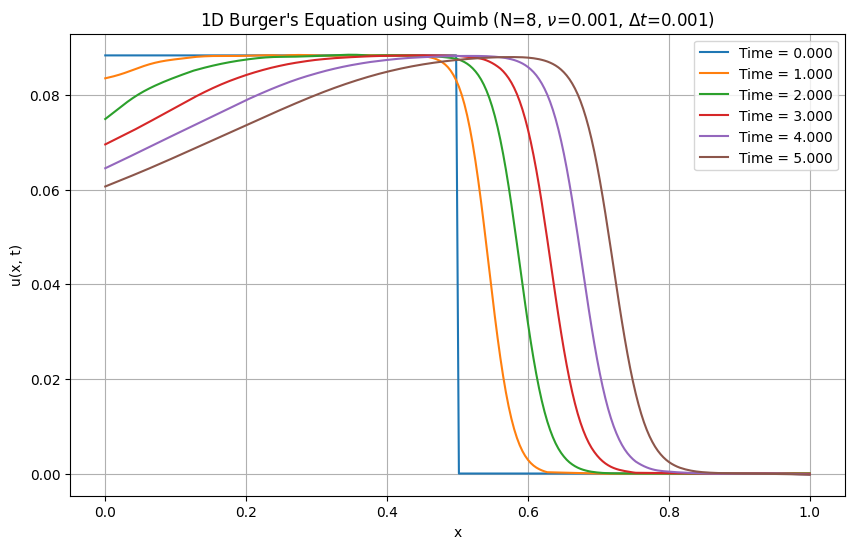


--- Important Considerations for Tensor Network Solvers ---
1. Non-Linear Term Handling: The `qtn.hadamard_product` performs an element-wise product, which is a direct way to compute `u * (du/dx)`. However, this operation can drastically increase the MPS bond dimension (product of input bond dimensions). For long-time simulations or higher accuracy, more sophisticated tensor network algorithms (e.g., Time-Dependent Variational Principle - TDVP) are often employed to handle non-linearities while keeping the bond dimension controlled and preserving the tensor network structure more effectively.
2. Truncation (`.compress()`): Frequent compression is crucial. The `max_bond` parameter directly controls the trade-off between accuracy and computational cost/memory. A smaller `max_bond` leads to faster computation but potentially less accurate results, especially if the true solution has high entanglement/correlation.
3. Boundary Conditions: The current implementation correctly uses periodic 

In [49]:
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags # For efficient creation of sparse matrices

# --- Parameters for the Simulation ---
N_sites = 8  # Number of sites (bits) in the MPS, so 2^N_sites grid points
N_grid_points = 2**N_sites # Total number of grid points
L_domain = 1  # Spatial domain length [0, 2*pi]
dx = L_domain / (N_grid_points - 1)  # Grid spacing (assuming endpoint=True)
nu = 0.001  # Kinematic viscosity (diffusion coefficient)
dt = 0.001  # Time step size
T_end = 5  # Total simulation time
max_bond = 30  # Maximum bond dimension allowed for MPS truncation

# --- Spatial Grid ---
# Create a 1D spatial grid with 2^N_sites points
x = np.linspace(0, L_domain, N_grid_points, endpoint=True)

# --- Initial Condition ---
# For Burger's equation, a common initial condition is a sine wave.
# u(x, 0) = sin(x)
u0_dense = np.sin(x)
u0_dense = riemann_step(N_grid_points)

# --- Convert Initial Condition to Matrix Product State (MPS) ---
# qtn.MPS.from_dense attempts to compress a dense vector into an MPS.
# The 'dims=2' means each site in the MPS corresponds to a binary index (a bit).
# 'bond_dim' is the initial maximum bond dimension for this compression.

u_mps = qtn.MPS_rand_state(L=20, bond_dim=max_bond)
u_mps = qtn.tensor_1d.MatrixProductState.from_dense(u0_dense, dims=2)
u_mps.compress(max_bond=max_bond)
#u_mps = qtn.MPS.from_dense(u0_dense, dims=2, bond_dim=max_bond)
print(f"Initial MPS bond dimensions (max): {u_mps.max_bond()}")

# --- Construct Matrix Product Operators (MPOs) for Burger's Equation Terms ---



from collections import Counter

def mps_elementwise_multiply(mps1, mps2):
    """
    Elementwise (Hadamard) product of two MPS.
    Assumes both have same number of sites.
    """

    # Count all index occurrences to find unique (physical) ones
    all_inds1 = [ind for tensor in mps1 for ind in tensor.inds]
    ind_counts1 = Counter(all_inds1)

    all_inds2 = [ind for tensor in mps2 for ind in tensor.inds]
    ind_counts2 = Counter(all_inds2)

    result_tensors = []
    C = mps1.copy()

    for i in range(8):
        A = mps1[i]
        B = mps2[i]

        # Physical index = appears only once in the network
        phys_ind_A = next(ind for ind in A.inds if ind_counts1[ind] == 1)
        phys_ind_B = next(ind for ind in B.inds if ind_counts2[ind] == 1)

        # Reindex B's physical index to match A's
        B = B.reindex({phys_ind_B: phys_ind_A})

        # Rename bond indices of B to avoid collisions with A
        B = B.reindex({ind: f"{ind}_b" for ind in B.inds if ind != phys_ind_A})

        # Multiply tensors (elementwise on physical index)
        result = A * B
        #result.modify(data=result.data * 0.1)
        C[i] = result

    return C


# Helper function to create periodic finite difference matrices




'''
def create_periodic_fd_matrix(N, dx, order):
    """
    Creates a dense periodic finite difference matrix for 1D.
    N: Number of grid points.
    dx: Grid spacing.
    order: 1 for first derivative, 2 for second derivative.
    """
    if order == 1:
        # First derivative: (u[i+1] - u[i-1]) / (2*dx)
        # Main diagonals: +1 on super-diagonal, -1 on sub-diagonal
        offsets = [1, -1]
        data = [np.full(N, 1.0 / (2 * dx)), np.full(N, -1.0 / (2 * dx))]
        # Handle periodic boundary conditions for the wrap-around elements
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()
        mat[0, N - 1] = -1.0 / (2 * dx) # u[0] depends on u[N-1]
        mat[N - 1, 0] = 1.0 / (2 * dx)  # u[N-1] depends on u[0]
    elif order == 2:
        # Second derivative: (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)
        # Main diagonals: +1 on super-diagonal, -2 on main diagonal, +1 on sub-diagonal
        offsets = [1, 0, -1]
        data = [np.full(N, 1.0 / (dx**2)),
                np.full(N, -2.0 / (dx**2)),
                np.full(N, 1.0 / (dx**2))]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()
        # Handle periodic boundary conditions
        mat[0, N - 1] = 1.0 / (dx**2)   # u[0] depends on u[N-1]
        mat[N - 1, 0] = 1.0 / (dx**2)   # u[N-1] depends on u[0]
    else:
        raise ValueError("Order must be 1 or 2 for finite difference.")
    return mat'''


import numpy as np
from scipy.sparse import diags

def create_dirichlet_fd_matrix(N, dx, order, left_bc=1.0, right_bc=0.0):
    """
    Create a dense finite difference matrix with Dirichlet boundary conditions applied
    directly to the matrix so that it sets u[0] = left_bc and u[-1] = right_bc.

    Parameters:
    - N (int): number of grid points
    - dx (float): grid spacing
    - order (int): 1 for first derivative, 2 for second derivative
    - left_bc (float): Dirichlet boundary value at the left end
    - right_bc (float): Dirichlet boundary value at the right end

    Returns:
    - mat (ndarray): NxN matrix that enforces Dirichlet BCs
    """
    if order == 1:
        # Central difference for interior points
        offsets = [-1, 1]
        data = [-np.ones(N) / (2 * dx), np.ones(N) / (2 * dx)]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()

        # Enforce Dirichlet BCs at boundaries
        mat[0, :] = 0.0
        mat[0, 0] = left_bc

        mat[-1, :] = 0.0
        mat[-1, -1] = right_bc

    elif order == 2:
        # Central difference for second derivative
        offsets = [-1, 0, 1]
        data = [np.ones(N) / dx**2,
                -2.0 * np.ones(N) / dx**2,
                np.ones(N) / dx**2]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()

        # Enforce Dirichlet BCs at boundaries
        mat[0, :] = 0.0
        mat[0, 0] = left_bc

        mat[-1, :] = 0.0
        mat[-1, -1] = right_bc

    else:
        raise ValueError("Order must be 1 or 2 for finite difference.")

    return mat

# Construct the dense matrices for the derivatives
D1_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=1)
D2_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=2)

# Convert dense matrices to MPOs
# The 'dims=2' specifies that each site in the MPO corresponds to a binary physical dimension.
MPO_dx = qtn.tensor_1d.MatrixProductOperator.from_dense(D1_dense_matrix, dims=2)
MPO_d2x = qtn.tensor_1d.MatrixProductOperator.from_dense(D2_dense_matrix, dims=2)

print(f"MPO for d/dx bond dimensions (max): {MPO_dx.max_bond()}")
print(f"MPO for d^2/dx^2 bond dimensions (max): {MPO_d2x.max_bond()}")

# --- Time Evolution Loop (Explicit Euler Method) ---
# The Burger's equation can be written as: ∂u/∂t = -u * (∂u/∂x) + ν * (∂^2u/∂x^2)
# Using Explicit Euler: u(t+dt) = u(t) + dt * ( -u * (∂u/∂x) + ν * (∂^2u/∂x^2) )
current_u_mps = u_mps.copy() # Start with the initial condition
num_steps = int(T_end / dt)

print(f"\nStarting simulation for {num_steps} steps (total time = {T_end})...")

current_u_mps /= current_u_mps.norm()
# Lists to store results for plotting
u_history = [current_u_mps.to_dense()] # Store initial state
times = [0.0]
for step in range(num_steps):
    # 1. Calculate the Viscous Term: ν * (∂^2u/∂x^2)
    # Apply the second derivative MPO to the current MPS.
    viscous_term_mps = MPO_d2x.apply(current_u_mps, compress=True)
    # Scale by the viscosity coefficient (nu).
    viscous_term_mps = viscous_term_mps * nu
    # Compress/truncate the MPS to control bond dimension growth after scaling.
    viscous_term_mps.compress(max_bond=max_bond)

    # 2. Calculate the Non-Linear Term: -u * (∂u/∂x)
    # First, calculate ∂u/∂dx by applying the first derivative MPO.
    du_dx_mps = MPO_dx.apply(current_u_mps, compress=True)
    du_dx_mps.compress(max_bond=max_bond)

    # Now, perform the element-wise product u * (du/dx).
    # qtn.hadamard_product performs an element-wise (Hadamard) product of two MPSs.
    # This operation can significantly increase the bond dimension, so immediate
    # compression is critical to maintain efficiency and prevent memory issues.
    nonlinear_term_mps = mps_elementwise_multiply(current_u_mps, du_dx_mps)
    nonlinear_term_mps.compress(max_bond=max_bond)

    # 3. Combine terms for the Right-Hand Side (RHS) of the equation:
    # RHS = - (u * du/dx) + (nu * d^2u/dx^2)
    # Perform MPS subtraction (which is handled as MPS addition with a negative scalar).
    rhs_mps = viscous_term_mps - nonlinear_term_mps
    rhs_mps.compress(max_bond=max_bond)

    # Scale the entire RHS by the time step (dt).
    rhs_mps = rhs_mps * dt
    rhs_mps.compress(max_bond=max_bond)

    # 4. Update u: u(t+dt) = u(t) + dt * RHS
    # Perform MPS addition to update the velocity field.
    current_u_mps = current_u_mps + rhs_mps
    # Final compression after the update to ensure bond dimension is controlled.
    current_u_mps.compress(max_bond=max_bond)

    # Print progress and current max bond dimension periodically
    if (step + 1) % (num_steps // 10) == 0 or step == num_steps - 1:
        print(f"  Step {step+1}/{num_steps}, Time: {(step + 1) * dt:.3f}, Max Bond Dim: {current_u_mps.max_bond()}")

    # Store data for plotting at certain intervals
    if (step + 1) % (num_steps // 5) == 0 or step == num_steps - 1:
        u_history.append(current_u_mps.to_dense())
        times.append((step + 1) * dt)

print("Simulation complete.")

# --- Plotting Results ---
plt.figure(figsize=(10, 6))
for i, u_dense in enumerate(u_history):
    plt.plot(x, u_dense, label=f'Time = {times[i]:.3f}')

plt.title(f'1D Burger\'s Equation using Quimb (N={N_sites}, $\\nu$={nu}, $\\Delta t$={dt})')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Important Considerations for Tensor Network Solvers ---")
print("1. Non-Linear Term Handling: The `qtn.hadamard_product` performs an element-wise product, which is a direct way to compute `u * (du/dx)`. However, this operation can drastically increase the MPS bond dimension (product of input bond dimensions). For long-time simulations or higher accuracy, more sophisticated tensor network algorithms (e.g., Time-Dependent Variational Principle - TDVP) are often employed to handle non-linearities while keeping the bond dimension controlled and preserving the tensor network structure more effectively.")
print("2. Truncation (`.compress()`): Frequent compression is crucial. The `max_bond` parameter directly controls the trade-off between accuracy and computational cost/memory. A smaller `max_bond` leads to faster computation but potentially less accurate results, especially if the true solution has high entanglement/correlation.")
print("3. Boundary Conditions: The current implementation correctly uses periodic boundary conditions by manually constructing the finite difference matrices. For other types of boundary conditions (e.g., Dirichlet, Neumann), the `create_periodic_fd_matrix` function would need to be adapted.")
print("4. Numerical Stability: The explicit Euler method, combined with finite differences, has stability limits (e.g., Courant-Friedrichs-Lewy - CFL condition). If `dt` is too large relative to `dx` and `nu`, the simulation can become unstable, leading to unphysical oscillations or divergence.")
print("5. Accuracy: The overall accuracy of the simulation depends on the spatial resolution (`N_sites`), temporal resolution (`dt`), and the chosen `max_bond` for truncation. Increasing these parameters generally improves accuracy but at a higher computational expense.")
print("6. MPO from Dense Matrix: For larger `N_sites` (e.g., beyond 12-14), constructing the full dense matrix for the MPO becomes memory and computationally prohibitive. For such cases, more advanced MPO construction techniques (e.g., using `qtn.local_op_sum` with carefully designed local operators that represent shifts in the binary coordinate space, or using algorithms to find the MPO representation of an operator) would be necessary to leverage the full power of tensor networks.")


In [ ]:
print(type(MPO_d2x))        # Should be <class 'quimb.tensor.tensor_1d.MPO'>
print(type(current_u_mps))

In [ ]:
from quimb.tensor import MPS_computational_state

# Create an MPS with artificially large bond dimension
mps = MPS_computational_state('010101', dtype='float64')
mps.expand_bond_dimension(50)

# Compress the MPS
mps.compress(cutoff=1e-10, max_bond=10)

In [59]:
for i in current_u_mps.sites:
  print(current_u_mps[i].shape)

(2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2, 1)
(1, 2)


In [60]:
for i in du_dx_mps.sites:
  print(du_dx_mps[i].shape)

(1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 2)


In [61]:
for i in viscous_term_mps.sites:
  print(viscous_term_mps[i].shape)

(1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 1, 2)
(1, 2)


In [62]:
du_dx_mps.sites

(0, 1, 2, 3, 4, 5, 6, 7)

Initial MPS bond dimensions (max): 1
MPO for d/dx bond dimensions (max): 5
MPO for d^2/dx^2 bond dimensions (max): 5

Starting simulation for 5000 steps (total time = 5)...
  Step 500/5000, Time: 0.500, Max Bond Dim: 4
  Step 1000/5000, Time: 1.000, Max Bond Dim: 4
  Step 1500/5000, Time: 1.500, Max Bond Dim: 4
  Step 2000/5000, Time: 2.000, Max Bond Dim: 4
  Step 2500/5000, Time: 2.500, Max Bond Dim: 4
  Step 3000/5000, Time: 3.000, Max Bond Dim: 4
  Step 3500/5000, Time: 3.500, Max Bond Dim: 4
  Step 4000/5000, Time: 4.000, Max Bond Dim: 4
  Step 4500/5000, Time: 4.500, Max Bond Dim: 4
  Step 5000/5000, Time: 5.000, Max Bond Dim: 4
Simulation complete.


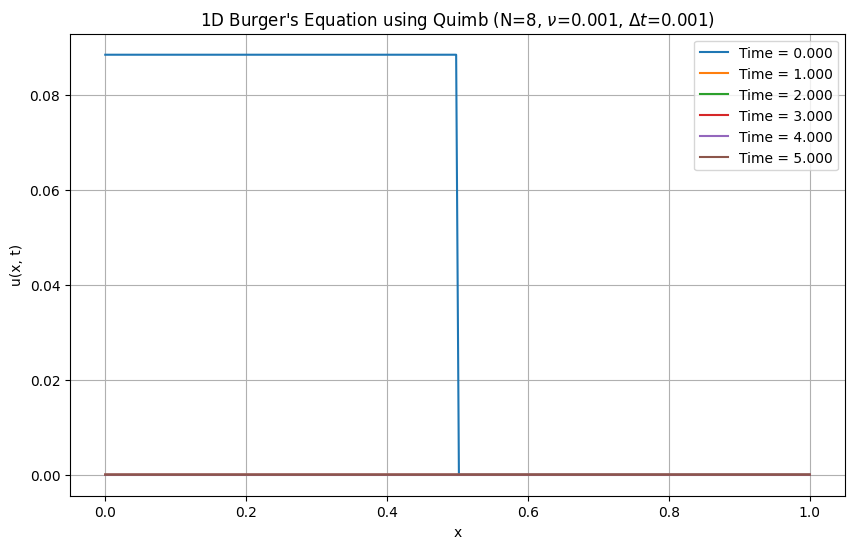


--- Important Considerations for Tensor Network Solvers ---
1. Non-Linear Term Handling: The `qtn.hadamard_product` performs an element-wise product, which is a direct way to compute `u * (du/dx)`. However, this operation can drastically increase the MPS bond dimension (product of input bond dimensions). For long-time simulations or higher accuracy, more sophisticated tensor network algorithms (e.g., Time-Dependent Variational Principle - TDVP) are often employed to handle non-linearities while keeping the bond dimension controlled and preserving the tensor network structure more effectively.
2. Truncation (`.compress()`): Frequent compression is crucial. The `max_bond` parameter directly controls the trade-off between accuracy and computational cost/memory. A smaller `max_bond` leads to faster computation but potentially less accurate results, especially if the true solution has high entanglement/correlation.
3. Boundary Conditions: The current implementation correctly uses periodic 

In [53]:
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags # For efficient creation of sparse matrices

# --- Parameters for the Simulation ---
N_sites = 8  # Number of sites (bits) in the MPS, so 2^N_sites grid points
N_grid_points = 2**N_sites # Total number of grid points
L_domain = 1  # Spatial domain length [0, 2*pi]
dx = L_domain / (N_grid_points - 1)  # Grid spacing (assuming endpoint=True)
nu = 0.001  # Kinematic viscosity (diffusion coefficient)
dt = 0.001  # Time step size
T_end = 5  # Total simulation time
max_bond = 30  # Maximum bond dimension allowed for MPS truncation

# --- Spatial Grid ---
# Create a 1D spatial grid with 2^N_sites points
x = np.linspace(0, L_domain, N_grid_points, endpoint=True)

# --- Initial Condition ---
# For Burger's equation, a common initial condition is a sine wave.
# u(x, 0) = sin(x)
u0_dense = np.sin(x)
u0_dense = riemann_step(N_grid_points)

# --- Convert Initial Condition to Matrix Product State (MPS) ---
# qtn.MPS.from_dense attempts to compress a dense vector into an MPS.
# The 'dims=2' means each site in the MPS corresponds to a binary index (a bit).
# 'bond_dim' is the initial maximum bond dimension for this compression.

u_mps = qtn.MPS_rand_state(L=20, bond_dim=max_bond)
u_mps = qtn.tensor_1d.MatrixProductState.from_dense(u0_dense, dims=2)
u_mps.compress(max_bond=max_bond)
#u_mps = qtn.MPS.from_dense(u0_dense, dims=2, bond_dim=max_bond)
print(f"Initial MPS bond dimensions (max): {u_mps.max_bond()}")

# --- Construct Matrix Product Operators (MPOs) for Burger's Equation Terms ---



from collections import Counter

def mps_elementwise_multiply(mps1, mps2):
    """
    Elementwise (Hadamard) product of two MPS.
    Assumes both have same number of sites.
    """

    # Count all index occurrences to find unique (physical) ones
    all_inds1 = [ind for tensor in mps1 for ind in tensor.inds]
    ind_counts1 = Counter(all_inds1)

    all_inds2 = [ind for tensor in mps2 for ind in tensor.inds]
    ind_counts2 = Counter(all_inds2)

    result_tensors = []
    C = mps1.copy()

    for i in range(8):
        A = mps1[i]
        B = mps2[i]

        # Physical index = appears only once in the network
        phys_ind_A = next(ind for ind in A.inds if ind_counts1[ind] == 1)
        phys_ind_B = next(ind for ind in B.inds if ind_counts2[ind] == 1)

        # Reindex B's physical index to match A's
        B = B.reindex({phys_ind_B: phys_ind_A})

        # Rename bond indices of B to avoid collisions with A
        B = B.reindex({ind: f"{ind}_b" for ind in B.inds if ind != phys_ind_A})

        # Multiply tensors (elementwise on physical index)
        result = A * B
        #result.modify(data=result.data * 0.1)
        C[i] = result

    return C


# Helper function to create periodic finite difference matrices




'''
def create_periodic_fd_matrix(N, dx, order):
    """
    Creates a dense periodic finite difference matrix for 1D.
    N: Number of grid points.
    dx: Grid spacing.
    order: 1 for first derivative, 2 for second derivative.
    """
    if order == 1:
        # First derivative: (u[i+1] - u[i-1]) / (2*dx)
        # Main diagonals: +1 on super-diagonal, -1 on sub-diagonal
        offsets = [1, -1]
        data = [np.full(N, 1.0 / (2 * dx)), np.full(N, -1.0 / (2 * dx))]
        # Handle periodic boundary conditions for the wrap-around elements
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()
        mat[0, N - 1] = -1.0 / (2 * dx) # u[0] depends on u[N-1]
        mat[N - 1, 0] = 1.0 / (2 * dx)  # u[N-1] depends on u[0]
    elif order == 2:
        # Second derivative: (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)
        # Main diagonals: +1 on super-diagonal, -2 on main diagonal, +1 on sub-diagonal
        offsets = [1, 0, -1]
        data = [np.full(N, 1.0 / (dx**2)),
                np.full(N, -2.0 / (dx**2)),
                np.full(N, 1.0 / (dx**2))]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()
        # Handle periodic boundary conditions
        mat[0, N - 1] = 1.0 / (dx**2)   # u[0] depends on u[N-1]
        mat[N - 1, 0] = 1.0 / (dx**2)   # u[N-1] depends on u[0]
    else:
        raise ValueError("Order must be 1 or 2 for finite difference.")
    return mat'''


import numpy as np
from scipy.sparse import diags

def create_dirichlet_fd_matrix(N, dx, order, left_bc=1.0, right_bc=0.0):
    """
    Create a dense finite difference matrix with Dirichlet boundary conditions applied
    directly to the matrix so that it sets u[0] = left_bc and u[-1] = right_bc.

    Parameters:
    - N (int): number of grid points
    - dx (float): grid spacing
    - order (int): 1 for first derivative, 2 for second derivative
    - left_bc (float): Dirichlet boundary value at the left end
    - right_bc (float): Dirichlet boundary value at the right end

    Returns:
    - mat (ndarray): NxN matrix that enforces Dirichlet BCs
    """
    if order == 1:
        # Central difference for interior points
        offsets = [-1, 1]
        data = [-np.ones(N) / (2 * dx), np.ones(N) / (2 * dx)]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()

        # Enforce Dirichlet BCs at boundaries
        mat[0, :] = 0.0
        mat[0, 0] = left_bc

        mat[-1, :] = 0.0
        mat[-1, -1] = right_bc

    elif order == 2:
        # Central difference for second derivative
        offsets = [-1, 0, 1]
        data = [np.ones(N) / dx**2,
                -2.0 * np.ones(N) / dx**2,
                np.ones(N) / dx**2]
        mat = diags(data, offsets, shape=(N, N), format='csc').toarray()

        # Enforce Dirichlet BCs at boundaries
        mat[0, :] = 0.0
        mat[0, 0] = left_bc

        mat[-1, :] = 0.0
        mat[-1, -1] = right_bc

    else:
        raise ValueError("Order must be 1 or 2 for finite difference.")

    return mat



def create_dirichlet_mpo(N_sites, left_proj=True, right_proj=True):
    """
    Create an MPO that enforces Dirichlet boundary projection.
    Assumes physical dimension = 2. Projects onto |1><1| at boundaries.

    Parameters:
    - N_sites: number of sites (bits)
    - left_proj: whether to apply projection on the left site
    - right_proj: whether to apply projection on the right site
    """
    tensors = []
    for i in range(N_sites):
        if i == 0 and left_proj:
            mat = np.zeros((2, 2))
            mat[1, 1] = 1.0
        elif i == N_sites - 1 and right_proj:
            mat = np.zeros((2, 2))
            mat[1, 1] = 1.0
        else:
            mat = np.eye(2)
    return qtn.tensor_1d.MatrixProductOperator.from_dense(mat, dims=2)



# Construct the dense matrices for the derivatives
D1_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=1)
D2_dense_matrix = create_dirichlet_fd_matrix(N_grid_points, dx, order=2)

# Convert dense matrices to MPOs
# The 'dims=2' specifies that each site in the MPO corresponds to a binary physical dimension.
MPO_dx = qtn.tensor_1d.MatrixProductOperator.from_dense(D1_dense_matrix, dims=2)
MPO_d2x = qtn.tensor_1d.MatrixProductOperator.from_dense(D2_dense_matrix, dims=2)
MPO_d = create_dirichlet_mpo(N_sites=N_sites)

print(f"MPO for d/dx bond dimensions (max): {MPO_dx.max_bond()}")
print(f"MPO for d^2/dx^2 bond dimensions (max): {MPO_d2x.max_bond()}")

# --- Time Evolution Loop (Explicit Euler Method) ---
# The Burger's equation can be written as: ∂u/∂t = -u * (∂u/∂x) + ν * (∂^2u/∂x^2)
# Using Explicit Euler: u(t+dt) = u(t) + dt * ( -u * (∂u/∂x) + ν * (∂^2u/∂x^2) )
current_u_mps = u_mps.copy() # Start with the initial condition
num_steps = int(T_end / dt)

print(f"\nStarting simulation for {num_steps} steps (total time = {T_end})...")

current_u_mps /= current_u_mps.norm()
# Lists to store results for plotting
u_history = [current_u_mps.to_dense()] # Store initial state
times = [0.0]
for step in range(num_steps):
    # 1. Calculate the Viscous Term: ν * (∂^2u/∂x^2)
    # Apply the second derivative MPO to the current MPS.
    viscous_term_mps = MPO_d2x.apply(current_u_mps, compress=True)
    # Scale by the viscosity coefficient (nu).
    viscous_term_mps = viscous_term_mps * nu
    # Compress/truncate the MPS to control bond dimension growth after scaling.
    viscous_term_mps.compress(max_bond=max_bond)

    # 2. Calculate the Non-Linear Term: -u * (∂u/∂x)
    # First, calculate ∂u/∂dx by applying the first derivative MPO.
    du_dx_mps = MPO_dx.apply(current_u_mps, compress=True)
    du_dx_mps.compress(max_bond=max_bond)

    # Now, perform the element-wise product u * (du/dx).
    # qtn.hadamard_product performs an element-wise (Hadamard) product of two MPSs.
    # This operation can significantly increase the bond dimension, so immediate
    # compression is critical to maintain efficiency and prevent memory issues.
    nonlinear_term_mps = mps_elementwise_multiply(current_u_mps, du_dx_mps)
    nonlinear_term_mps.compress(max_bond=max_bond)

    # 3. Combine terms for the Right-Hand Side (RHS) of the equation:
    # RHS = - (u * du/dx) + (nu * d^2u/dx^2)
    # Perform MPS subtraction (which is handled as MPS addition with a negative scalar).
    rhs_mps = viscous_term_mps - nonlinear_term_mps
    rhs_mps.compress(max_bond=max_bond)

    # Scale the entire RHS by the time step (dt).
    rhs_mps = rhs_mps * dt
    rhs_mps.compress(max_bond=max_bond)

    # 4. Update u: u(t+dt) = u(t) + dt * RHS
    # Perform MPS addition to update the velocity field.
    current_u_mps = current_u_mps + rhs_mps
    # Final compression after the update to ensure bond dimension is controlled.
    current_u_mps.compress(max_bond=max_bond)

    current_u_mps = MPO_d.apply(current_u_mps)
    current_u_mps.compress(max_bond=max_bond)

    # Print progress and current max bond dimension periodically
    if (step + 1) % (num_steps // 10) == 0 or step == num_steps - 1:
        print(f"  Step {step+1}/{num_steps}, Time: {(step + 1) * dt:.3f}, Max Bond Dim: {current_u_mps.max_bond()}")

    # Store data for plotting at certain intervals
    if (step + 1) % (num_steps // 5) == 0 or step == num_steps - 1:
        u_history.append(current_u_mps.to_dense())
        times.append((step + 1) * dt)

print("Simulation complete.")

# --- Plotting Results ---
plt.figure(figsize=(10, 6))
for i, u_dense in enumerate(u_history):
    plt.plot(x, u_dense, label=f'Time = {times[i]:.3f}')

plt.title(f'1D Burger\'s Equation using Quimb (N={N_sites}, $\\nu$={nu}, $\\Delta t$={dt})')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Important Considerations for Tensor Network Solvers ---")
print("1. Non-Linear Term Handling: The `qtn.hadamard_product` performs an element-wise product, which is a direct way to compute `u * (du/dx)`. However, this operation can drastically increase the MPS bond dimension (product of input bond dimensions). For long-time simulations or higher accuracy, more sophisticated tensor network algorithms (e.g., Time-Dependent Variational Principle - TDVP) are often employed to handle non-linearities while keeping the bond dimension controlled and preserving the tensor network structure more effectively.")
print("2. Truncation (`.compress()`): Frequent compression is crucial. The `max_bond` parameter directly controls the trade-off between accuracy and computational cost/memory. A smaller `max_bond` leads to faster computation but potentially less accurate results, especially if the true solution has high entanglement/correlation.")
print("3. Boundary Conditions: The current implementation correctly uses periodic boundary conditions by manually constructing the finite difference matrices. For other types of boundary conditions (e.g., Dirichlet, Neumann), the `create_periodic_fd_matrix` function would need to be adapted.")
print("4. Numerical Stability: The explicit Euler method, combined with finite differences, has stability limits (e.g., Courant-Friedrichs-Lewy - CFL condition). If `dt` is too large relative to `dx` and `nu`, the simulation can become unstable, leading to unphysical oscillations or divergence.")
print("5. Accuracy: The overall accuracy of the simulation depends on the spatial resolution (`N_sites`), temporal resolution (`dt`), and the chosen `max_bond` for truncation. Increasing these parameters generally improves accuracy but at a higher computational expense.")
print("6. MPO from Dense Matrix: For larger `N_sites` (e.g., beyond 12-14), constructing the full dense matrix for the MPO becomes memory and computationally prohibitive. For such cases, more advanced MPO construction techniques (e.g., using `qtn.local_op_sum` with carefully designed local operators that represent shifts in the binary coordinate space, or using algorithms to find the MPO representation of an operator) would be necessary to leverage the full power of tensor networks.")
